# Data-Center Energy Use in the AI Era

This notebook visualizes a simple model of **global data-center electricity use**
and **CO₂ emissions** before and after the rapid growth of AI workloads.

The numbers are based on:

- Public estimates from the **International Energy Agency (IEA)** for total
  data-center electricity use (TWh/year).
- An illustrative **AI share of total load** that grows over time
  (near 0% in 2015, ~7% in 2024, ~35% in 2030).
- Two simple **grid carbon-intensity trajectories**:
  - Base-case grid
  - Cleaner grid with faster decarbonization

The goal is not to be a perfect forecast, but to give a **clear visual story**
of how AI changes data-center energy use and emissions.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (10, 6)

# ============================================================
# 1. IEA-based historical data (TWh)
# ============================================================

data_hist = {
    2015: 200,                 # ~200 TWh in 2015
    2018: 200,                 # ~200 TWh in 2018
    2020: (200 + 250) / 2,     # 200–250 TWh  -> 225
    2021: (220 + 320) / 2,     # 220–320 TWh  -> 270
    2022: (240 + 340) / 2,     # 240–340 TWh  -> 290
    2024: 415                  # ~415 TWh in 2024
}

df_hist = (
    pd.Series(data_hist, name="twh")
    .reset_index()
    .rename(columns={"index": "year"})
    .sort_values("year")
    .reset_index(drop=True)
)

# ============================================================
# 2. Project to 2030 using IEA base-case growth (~doubling)
# ============================================================

start_year = 2024
end_year = 2030
years_proj = np.arange(start_year, end_year + 1)

target_2030_twh = 945  # IEA base-case 2030 estimate
growth_rate = (target_2030_twh / 415) ** (1 / (end_year - start_year)) - 1

proj_values = [data_hist[start_year]]
for _ in range(start_year + 1, end_year + 1):
    proj_values.append(proj_values[-1] * (1 + growth_rate))

df_proj = pd.DataFrame({
    "year": years_proj,
    "twh_base_case": proj_values
})

df_energy = pd.concat(
    [
        df_hist,
        df_proj[df_proj["year"] > df_hist["year"].max()].rename(
            columns={"twh_base_case": "twh"}
        ),
    ],
    ignore_index=True,
)

years_all = df_energy["year"].values

# ============================================================
# 3. Carbon-intensity trajectories (gCO2/kWh)
# ============================================================

base_case_intensity_points = {2015: 450, 2024: 380, 2030: 320}
clean_grid_intensity_points = {2015: 450, 2024: 350, 2030: 250}

def interpolate_intensity(years, anchor_dict):
    anchor_years = np.array(sorted(anchor_dict.keys()))
    anchor_vals = np.array([anchor_dict[y] for y in anchor_years])
    return np.interp(years, anchor_years, anchor_vals)

df_energy["intensity_base"] = interpolate_intensity(years_all, base_case_intensity_points)
df_energy["intensity_clean"] = interpolate_intensity(years_all, clean_grid_intensity_points)

# ============================================================
# 4. AI vs non-AI energy share (illustrative)
# ============================================================

# AI share of total data-centre electricity:
# - 0% in 2015
# - ~1% in 2020
# - ~7% in 2024 (~30 TWh of ~415 TWh)
# - ~35% in 2030

ai_share_points = {2015: 0.00, 2020: 0.01, 2024: 0.07, 2030: 0.35}

def interpolate_share(years, anchor_dict):
    anchor_years = np.array(sorted(anchor_dict.keys()))
    anchor_vals = np.array([anchor_dict[y] for y in anchor_years])
    return np.interp(years, anchor_years, anchor_vals)

df_energy["ai_share_mid"] = interpolate_share(years_all, ai_share_points)
df_energy["ai_twh_mid"] = df_energy["twh"] * df_energy["ai_share_mid"]
df_energy["non_ai_twh_mid"] = df_energy["twh"] - df_energy["ai_twh_mid"]

# ============================================================
# 5. CO2 emissions (MtCO2)
# ============================================================

df_energy["mtco2_base"] = df_energy["twh"] * df_energy["intensity_base"] / 1000.0
df_energy["mtco2_clean"] = df_energy["twh"] * df_energy["intensity_clean"] / 1000.0

df_energy["ai_mtco2_mid"] = df_energy["ai_twh_mid"] * df_energy["intensity_base"] / 1000.0
df_energy["non_ai_mtco2_mid"] = df_energy["non_ai_twh_mid"] * df_energy["intensity_base"] / 1000.0

df_energy


,year,twh,intensity_base,intensity_clean,ai_share_mid,ai_twh_mid,non_ai_twh_mid,mtco2_base,mtco2_clean,ai_mtco2_mid,non_ai_mtco2_mid
0,2015,200.000000,450.000000,450.000000,0.000000,0.000000,200.000000,90.000000,90.000000,0.000000,90.000000
1,2018,200.000000,426.666667,416.666667,0.006000,1.200000,198.800000,85.333333,83.333333,0.512000,84.821333
2,2020,225.000000,411.111111,394.444444,0.010000,2.250000,222.750000,92.500000,88.750000,0.925000,91.575000
3,2021,270.000000,403.333333,383.333333,0.025000,6.750000,263.250000,108.900000,103.500000,2.722500,106.177500
4,2022,290.000000,395.555556,372.222222,0.040000,11.600000,278.400000,114.711111,107.944444,4.588444,110.122667
5,2024,415.000000,380.000000,350.000000,0.070000,29.050000,385.950000,157.700000,145.250000,11.039000,146.661000
6,2025,476.005585,370.000000,333.333333,0.116667,55.533985,420.471600,176.122067,158.668528,20.547574,155.574492
7,2026,545.979078,360.000000,316.666667,0.163333,89.176583,456.802495,196.552468,172.893375,32.103570,164.448898
8,2027,626.238772,350.000000,300.000000,0.210000,131.510142,494.728630,219.183570,187.871632,46.028550,173.155021
9,2028,718.296755,340.000000,283.333333,0.256667,184.362834,533.933921,244.220897,203.517414,62.683364,181.537533


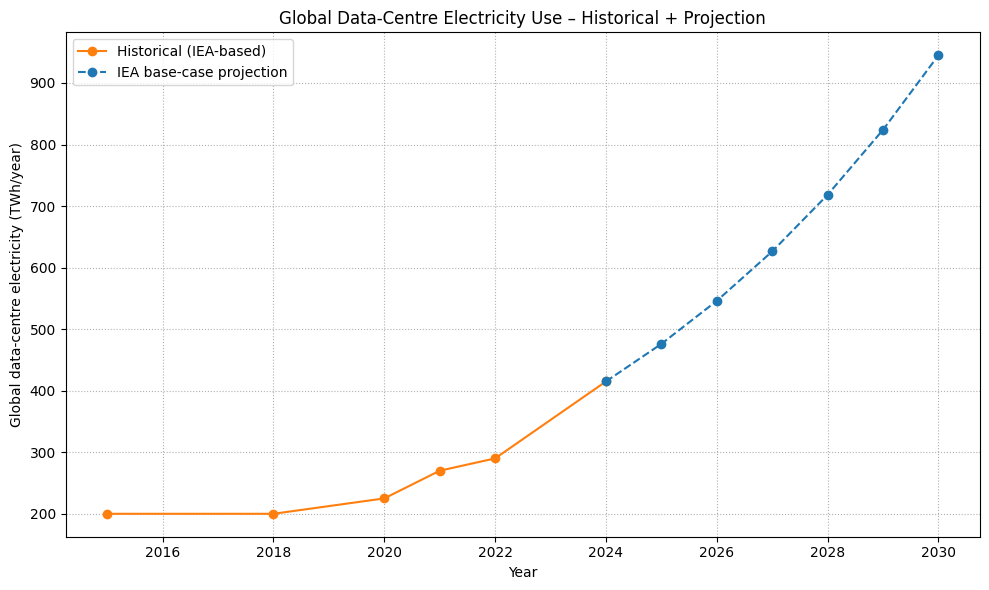

In [2]:
plt.figure()
mask_hist = df_energy["year"] <= 2024
plt.plot(
    df_energy.loc[mask_hist, "year"],
    df_energy.loc[mask_hist, "twh"],
    marker="o",
    color="tab:orange",
    label="Historical (IEA-based)",
)
mask_proj = df_energy["year"] >= 2024
plt.plot(
    df_energy.loc[mask_proj, "year"],
    df_energy.loc[mask_proj, "twh"],
    marker="o",
    linestyle="--",
    color="tab:blue",
    label="IEA base-case projection",
)
plt.xlabel("Year")
plt.ylabel("Global data-centre electricity (TWh/year)")
plt.title("Global Data-Centre Electricity Use – Historical + Projection")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()


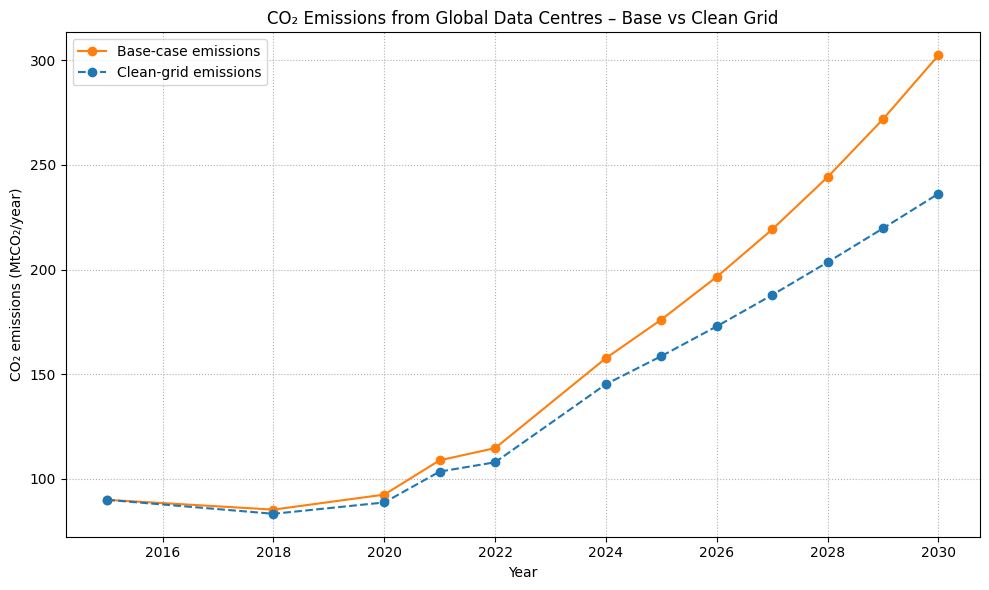

In [3]:
plt.figure()
plt.plot(
    df_energy["year"],
    df_energy["mtco2_base"],
    marker="o",
    color="tab:orange",
    label="Base-case emissions",
)
plt.plot(
    df_energy["year"],
    df_energy["mtco2_clean"],
    marker="o",
    linestyle="--",
    color="tab:blue",
    label="Clean-grid emissions",
)
plt.xlabel("Year")
plt.ylabel("CO₂ emissions (MtCO₂/year)")
plt.title("CO₂ Emissions from Global Data Centres – Base vs Clean Grid")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()


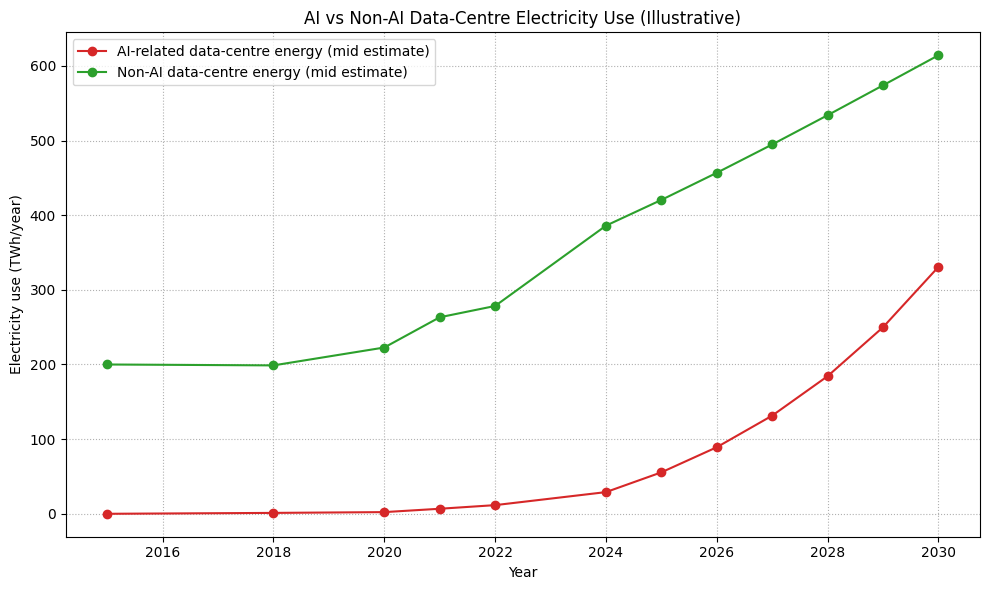

In [4]:
plt.figure()
plt.plot(
    df_energy["year"],
    df_energy["ai_twh_mid"],
    marker="o",
    color="tab:red",
    label="AI-related data-centre energy (mid estimate)",
)
plt.plot(
    df_energy["year"],
    df_energy["non_ai_twh_mid"],
    marker="o",
    color="tab:green",
    label="Non-AI data-centre energy (mid estimate)",
)
plt.xlabel("Year")
plt.ylabel("Electricity use (TWh/year)")
plt.title("AI vs Non-AI Data-Centre Electricity Use (Illustrative)")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()


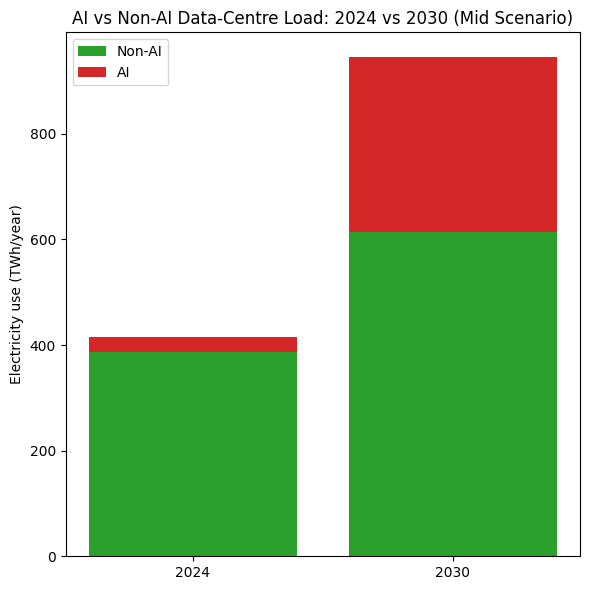

In [5]:
years_focus = [2024, 2030]
df_focus = df_energy[df_energy["year"].isin(years_focus)].set_index("year")

plt.figure(figsize=(6, 6))
x = np.arange(len(years_focus))
ai_vals = df_focus["ai_twh_mid"].values
non_ai_vals = df_focus["non_ai_twh_mid"].values

plt.bar(x, non_ai_vals, label="Non-AI", color="tab:green")
plt.bar(x, ai_vals, bottom=non_ai_vals, label="AI", color="tab:red")

plt.xticks(x, years_focus)
plt.ylabel("Electricity use (TWh/year)")
plt.title("AI vs Non-AI Data-Centre Load: 2024 vs 2030 (Mid Scenario)")
plt.legend()
plt.tight_layout()
plt.show()


## Quick Interpretation

- **Total electricity**: Global data-centre usage is roughly flat until the
  late 2010s, then rises and is projected to almost double by 2030.
- **Emissions**: If grids decarbonize slowly, CO₂ emissions climb with energy.
  A cleaner grid can substantially reduce emissions even with high compute.
- **AI vs non-AI**: Non-AI workloads dominate today, but AI grows much faster
  and becomes a large fraction of data-centre energy by 2030 in this scenario.
